LOAD MODEL

In [179]:
import torch
model = torch.hub.load('yolov5-lib-ds', 
                       'custom', 
                       path='best.pt',
                       source='local',
                       force_reload=True)  
model.conf = 0.28 # model confidence
model.iou  = 0.5  # NMS IoU threshold

YOLOv5 🚀 d873d60 torch 1.10.0 CPU

Fusing layers... 
Model Summary: 280 layers, 12308200 parameters, 0 gradients, 16.2 GFLOPs
Adding AutoShape... 


In [180]:
def voc2yolo(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes
    
def yolo2coco(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2coco(bboxes, image_height=720, image_width=1280):
    bboxes  = voc2yolo(bboxes, image_height, image_width)
    bboxes  = yolo2coco(bboxes, image_height, image_width)
    return bboxes



MAKE PREDICTION

In [181]:
import cv2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

image_id = '1-9114'
img = './test_images/1_9114.jpg'
IMAGE=cv2.imread(img)

r = model(IMAGE, size=10000, augment=True)

cpu


/Users/marcblomvliet/Library/Python/3.7/lib/python/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [182]:
anno = ''
predictions = []

total_pred = []
if r.pandas().xyxy[0].shape[0] == 0:
    anno = ''
else:
    for idx, row in r.pandas().xyxy[0].iterrows():
        if row.confidence > 0.15:
            predictions2 = []
            predictions.append('{:.2f} {} {} {} {}'.format(row.confidence, row.xmin, row.ymin, row.xmax-row.xmin, row.ymax-row.ymin))
            predictions2.append(row.xmin)
            predictions2.append(row.ymin)
            predictions2.append(row.xmax-row.xmin)
            predictions2.append(row.ymax-row.ymin)
            total_pred.append(predictions2)
            print(row.confidence)

print(total_pred)


0.4435007572174072
[[631.2280883789062, 323.5799255371094, 43.00311279296875, 44.116729736328125]]


In [183]:
# === Show image and annotations if applicable ===
%matplotlib inline
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def show_image(path, annot, axs=None):
    if axs==None:
        fig, axs = plt.subplots(figsize=(23, 8))
    
    img = plt.imread(path)
    

    if annot:
        for a in annot:
            print(a)
            rect = patches.Rectangle((a[0], a[1]), a[2], a[3], 
                                     linewidth=3, edgecolor="#FF6103", facecolor='none')
            axs.add_patch(rect)
            axs.annotate("Starfish", (a[0], a[1]), color='w', weight='bold', 
                fontsize=10, va='center')

    axs.axis("off")
    axs.imshow(img)
    plt.show()

PREDICTION WITH MODEL ON IMAGE

./test_images/1_9114.jpg
[631.2280883789062, 323.5799255371094, 43.00311279296875, 44.116729736328125]


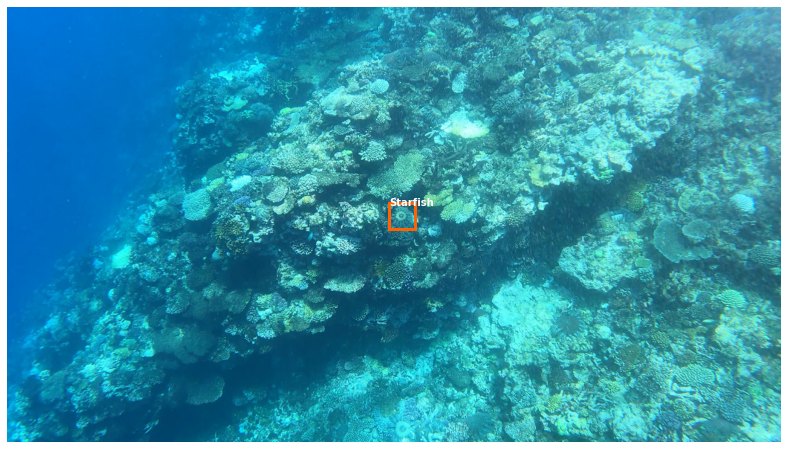

In [184]:
path=img
print(path)

show_image(path, total_pred, axs=None)

CHECK IT WITH ORIGINAL IMAGE

In [185]:
# === Show image and annotations if applicable ===
def show_image_original(path, annot, axs=None):
    if axs==None:
        fig, axs = plt.subplots(figsize=(23, 8))
    
    img = plt.imread(path)
    axs.imshow(img)

    if annot:
        for a in eval(annot):
            rect = patches.Rectangle((a["x"], a["y"]), a["width"], a["height"], 
                                     linewidth=3, edgecolor="#FF6103", facecolor='none')
            axs.add_patch(rect)
            axs.annotate("Starfish", (a["x"], a["y"]), color='w', weight='bold', 
                fontsize=10, va='center')

    axs.axis("off")

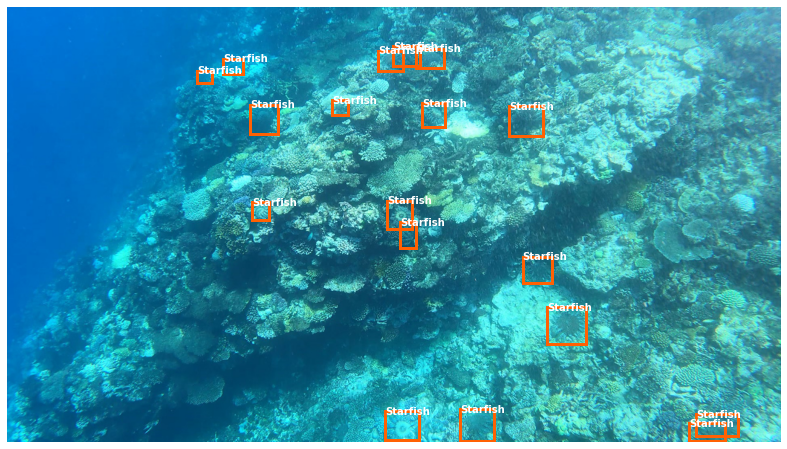

In [186]:
import pandas as pd

train_df = pd.read_csv("./train.csv")
#manually
x=train_df.loc[train_df['image_id'] == image_id]
annot = list(x['annotations'])[0]
show_image_original(path, annot, axs=None)